## Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Contents

* [1.1 Environment Setup](#env-setup)
    * [1.1.1 Importing Modules](#imports)
    * [1.1.2 Display Settings](#display-setup)
    * [1.1.3 Load Data](#read-file)
<br><br>
* [1.2 Preparing Data for Feature Selection](#eda)
    * [1.2.1 Grouping Variables by Type](#var-type)
    * [1.2.2 Remove Abnormal Sales](#ras)
    * [1.2.3 Combining Number Basement Bathrooms](#cnbb)
    * [1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations](#rnf)
    * [1.2.5 Remove Nominal Variables With Less Than 20% of Unique Observations](#rnf)
    * [1.2.6 Converting Ordinal Variables to Numeric](#covn)
    * [1.2.7 Dummifying Nominal Variables](#dnr)
    * [1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)](#imcm)
    * [1.2.9 Correlation Against Target Variable (SalePrice)](#catv)
    * [1.2.10 Checking for Normality: Dependent Variable](#cndv)
    * [1.2.11 Checking for Linearity Between Dependent Variable and Independent Continuous Variables](#cniv)
<br><br>
* [1.3 Feature Selection](#fs)
    * [1.3.1 Using Lasso Regression to Select Features](#lasso)
<br><br>
* [1.4 Descriptive Modeling](#dm)
    * [1.4.1 Train and Test data](#ttd)
    * [1.4.2 Multiple Linear Regression with all the features](#mlr)
    * [1.4.3 Multiple Linear Regresion with limited number of features](#mlr2)
    * [1.4.4 Evaluating p-values and R-squared using Statmodels](#statmodel)
    * [1.4.5 Further narrowing of the number of features](#fnnf)
<br><br>
* [1.5 Write Prepared Dataset and Encoded Dataset to Files](#writefile)

### 1.1 Environment Setup  <a class="anchor" id="env-setup"></a>

#### 1.1.1 Importing Modules<a class="anchor" id="imports"></a>

In [96]:
# import modules
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import warnings
import statsmodels.formula.api as smf
from scipy import stats
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

#### 1.1.2 Display Settings<a class="anchor" id="display-setup"></a>

In [97]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### 1.1.3 Load data<a class="anchor" id="read-file"></a>

In [98]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../data/Price_Data_cleaned.csv')

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.2 Preparing Data for Modeling<a class="anchor" id="eda"></a>

#### 1.2.1 Grouping Variables by Type<a class="anchor" id="var-type"></a>

In [99]:
continuous_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### 1.2.2 Remove Abnormal Sales<a class="anchor" id="ras"></a>
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations.

In [100]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [101]:
# Drop SaleCondition since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

#### 1.2.3 Combining Number Basement Bathrooms<a class="anchor" id="cnbb"></a>

In [102]:
# Combine BsmtFullBath and BsmtHalfBath
dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath'] / dataset['BsmtHalfBath'].max()
# Total number of bathrooms above grade
dataset['TotalNumBath'] = dataset['FullBath'] + dataset['HalfBath'] / dataset['HalfBath'].max()
# Drop orginal features
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], inplace=True)

#### 1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [103]:
# Removing the following features since they are only present in less than 20% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/dataset.shape[0]).sort_values(ascending=False).head(10)


PoolArea         0.996270
3SsnPorch        0.988396
LowQualFinSF     0.987153
MiscVal          0.961044
ScreenPorch      0.912143
BsmtFinSF2       0.867799
EnclosedPorch    0.839619
MasVnrArea       0.615416
2ndFlrSF         0.562785
BsmtNumBath      0.522586
dtype: float64

In [104]:
dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch','BsmtFinSF2','EnclosedPorch'], axis=1, inplace=True)

#### 1.2.5 Remove Nominal Variables With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [105]:
# Removing the following nominal variables since they are only present in less than 20% of the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(10)

PoolQC          0.996270
MiscFeature     0.960215
Alley           0.936179
Fence           0.791960
MasVnrType      0.618317
FireplaceQu     0.482387
GarageCond      0.048073
GarageQual      0.048073
GarageFinish    0.048073
GarageType      0.048073
dtype: float64

In [106]:
dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

#### 1.2.6 Converting Ordinal Variables to Numeric<a class="anchor" id="covn"></a>

In [107]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### 1.2.7 Dummifying Nominal Variables<a class="anchor" id="dnr"></a>

In [108]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [109]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

#### 1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)<a class="anchor" id="imcm"></a>

In [110]:
continuous_variables_updated = list(set(continuous_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea','BsmtFinSF2','EnclosedPorch']))

In [111]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continuous_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [112]:
# List of highly (>0.85) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.85:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

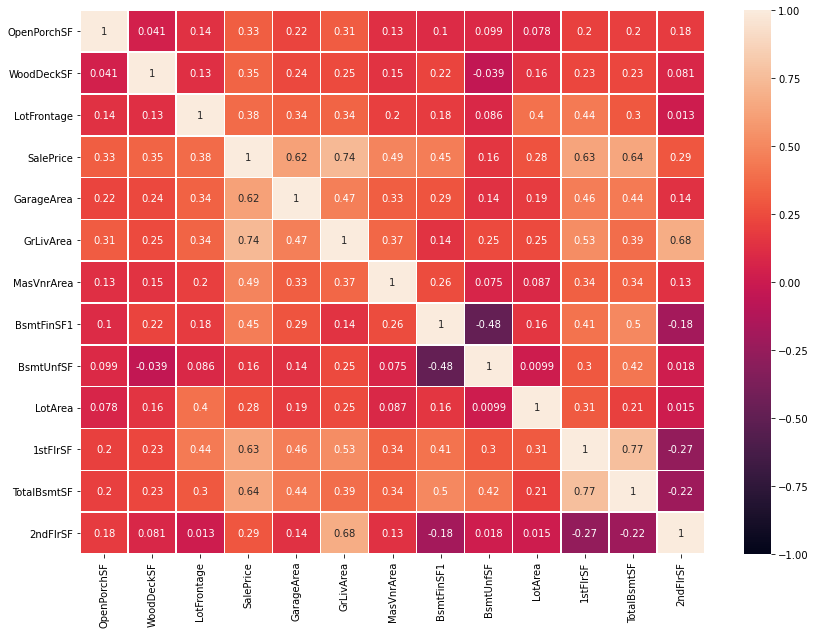

In [113]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<b>Conclusion:</b> correlation between features is within reasonable values, no feature will be removed.

#### 1.2.9 Correlation Against Target Variable (SalePrice)<a class="anchor" id="catv"></a>

In [114]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice      1.000000
GrLivArea      0.736036
TotalBsmtSF    0.642354
1stFlrSF       0.634672
GarageArea     0.621900
MasVnrArea     0.486620
BsmtFinSF1     0.454087
LotFrontage    0.382420
WoodDeckSF     0.350127
OpenPorchSF    0.326489
2ndFlrSF       0.293338
LotArea        0.275066
BsmtUnfSF      0.159724
Name: SalePrice, dtype: float64

<b>Conslusion:</b> no features will be removed since correlation between target variable and features is within reasonable values.


#### 1.2.10 Checking for Linearity: Dependent Variable<a class="anchor" id="cndv"></a>

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


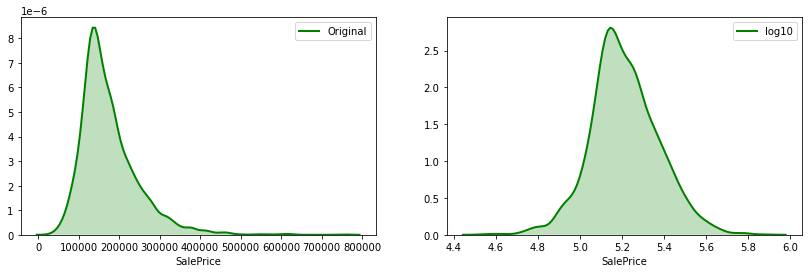

In [115]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### 1.2.11 Linear Relationship between Dependent Variable and Independent Continuous Variables<a class="anchor" id="cniv"></a>

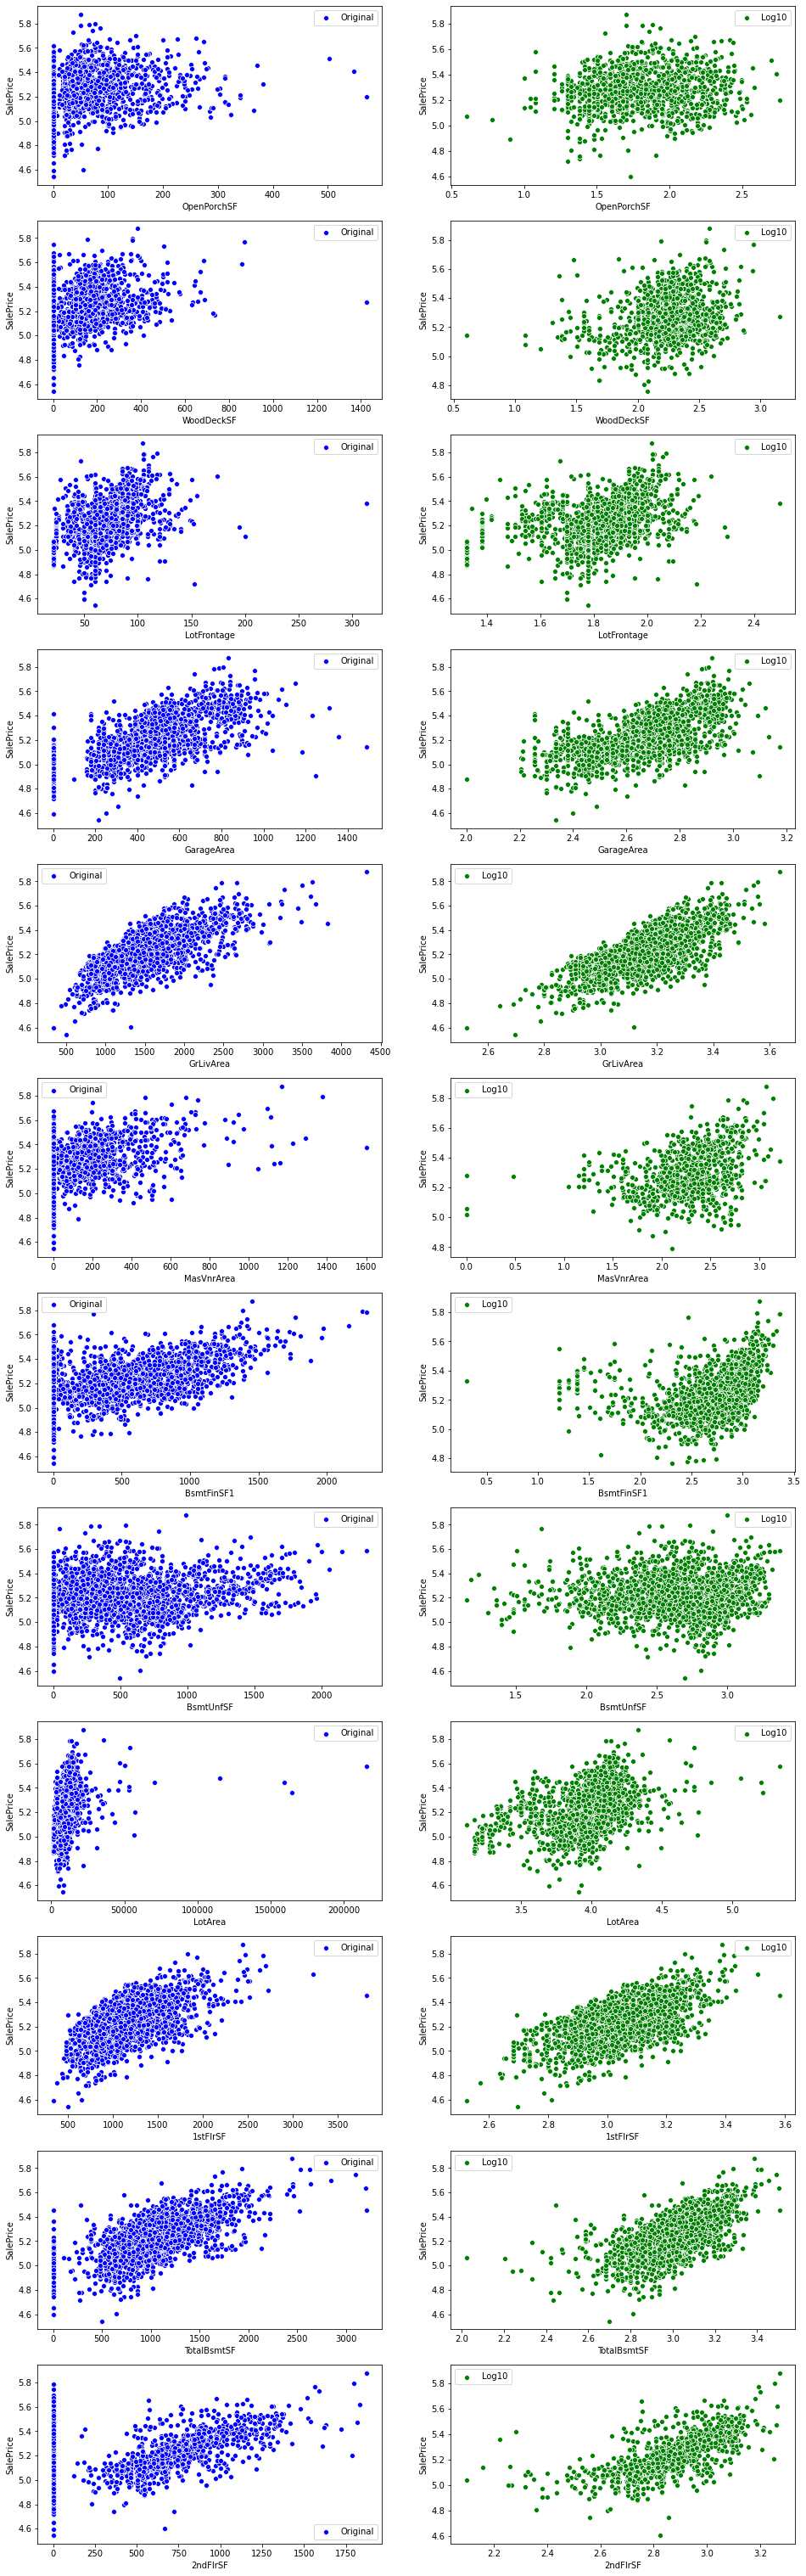

In [120]:
# Checking for linearity between SalePrice and all the continuous variables
continuous_variables_updated.remove('SalePrice')   # Do not include SalePrice
fig, ax = plt.subplots(dataset_encoded[continuous_variables_updated].shape[1], 2,  figsize=(16,55))

for i,feature in enumerate(continuous_variables_updated):
    original_data = dataset_encoded[feature]+1
    sns.scatterplot(x=dataset_encoded[feature], y=np.log10(dataset_encoded["SalePrice"]),
                    label = "Original", color ="blue", ax = ax[i,0])
    sns.scatterplot(x=np.log10(dataset_encoded[feature].astype('float')), y=np.log10(dataset_encoded["SalePrice"]),
                    label = "Log10", color ="green", ax = ax[i,1])

<b>Conclusion:</b> we will take the log10 of the following features: 1stFirSF, GrLivArea, and LotArea

In [121]:
# After inspecting the scatter plots above we decided to take the log10 of the following features:
# GrLivArea, LotArea, 1stFlrSF, 2ndFlrSF, GarageArea, TotalBsmSF
dataset_encoded['log10_GrLivArea'] = np.log10(dataset_encoded['GrLivArea'])
dataset_encoded['log10_LotArea'] = np.log10(dataset_encoded['LotArea'])
dataset_encoded['log10_1stFlrSF'] = np.log10(dataset_encoded['1stFlrSF']+1)     # +1 : This means we are adding bias, but is needed for zero
# Remove original columns
dataset_encoded.drop(columns=['GrLivArea','LotArea','1stFlrSF'], inplace=True)

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.3 Feature Selection<a class="anchor" id="fs"></a>

#### 1.3.1 Using Lasso Regression to Select Features<a class="anchor" id="lasso"></a>

In [24]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']              # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range (0,1).

In [25]:
# Using Lasso to select features
clf = LassoCV(alphas=np.arange(0.0001, 0.01)).fit(X_norm, y)   # set alpha low to ensure the features will have more relevance
importance = np.abs(clf.coef_)

In [26]:
# create dataframe Feature - Importance
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])
# dataframe
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})

In [27]:
# top 20 features with highest importance value
lasso_generated_features = list(feature_score.sort_values(by="Score", ascending=False).head(20)['feature'])

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.4 Descriptive Modeling<a class="anchor" id="dm"></a>

#### 1.4.1 Train and Test data<a class="anchor" id="ttd"></a>

In [28]:
# dataset -> Includes all features - Ordinal features encoded, Nominal features not dummified.
# dataset_encoded.shape -> Includes all features - Ordinal and Nominal features encoded/dummified.
# X -> Same as dataset_encoded without SalePrice feature
# Y -> Same as dataset_encoded but only SalePrice feature
# X_norm -> Same as X but all the numerical values scaled (0,1)

In [29]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

#### 1.4.2 Multiple Linear Regression with all the features<a class="anchor" id="mlr"></a>

In [30]:
# Create model: Multiple Linear Regression
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [31]:
# # Calculate R-squared (score) using Training data
mlr_model.score(X_train,np.log(y_train))

0.959624961287974

In [32]:
# Calculate R-squared (score) using Test data
mlr_model.score(X_test,np.log(y_test))

0.9353803397712688

#### 1.4.3 Multiple Linear Regresion with limited number of features<a class="anchor" id="mlr2"></a>

In [33]:
# Fit model with training data using Lasso generated features (top 20)
mlr_model.fit(X_train[lasso_generated_features], np.log10(y_train))
# Calculate R-squared (score) using training data
mlr_model.score(X_train[lasso_generated_features], np.log10(y_train))

0.9209162955514257

In [34]:
# Calculate R-squared (score) using test data
mlr_model.score(X_test[lasso_generated_features], np.log10(y_test))

0.9182176601933658

In [35]:
# Coefficients for features
for i, name_c in enumerate(lasso_generated_features):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

log10_1stFlrSF:  0.230083
TotalBsmtSF:  0.000079
Condition2_PosA:  0.043557
2ndFlrSF:  0.000081
Neighborhood_GrnHill:  0.164508
log10_LotArea:  0.109813
OverallQual:  0.037370
RoofMatl_WdShngl:  0.004379
Condition2_PosN:  0.050021
MasVnrArea:  0.000027
Exterior2nd_PreCast:  0.175791
GarageType_None:  -0.028972
YearBuilt:  0.001531
log10_GrLivArea:  0.221022
OverallCond:  0.022255
Heating_OthW:  -0.044454
BsmtUnfSF:  -0.000041
BsmtCond:  0.006394
Condition2_RRAn:  0.000000
BedroomAbvGr:  -0.014778


#### 1.4.4 Evaluating p-values and R-squared using Statmodels<a class="anchor" id="statmodel"></a>

In [36]:
# Statmodels does not like feature names starting with a number
X_stat = dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})
y_stat = dataset['SalePrice']
# Split data 70/30
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.30, random_state=10)
smf_model_features = lasso_generated_features
smf_model_features[3] = 'FlrSF2nd'

In [37]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1023.
Date:                 Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                         15:48:31   Log-Likelihood:                 2802.7
No. Observations:                 1689   AIC:                            -5565.
Df Residuals:                     1669   BIC:                            -5457.
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [38]:
# Decided to remove the following features whose Statistical Significance is low and some of the nominal features
smf_model_features = set(lasso_generated_features) - set(['Condition2_PosA','RoofMatl_WdShngl',
                                                          'Condition2_PosN','Heating_OthW','Condition2_RRAn'])

In [39]:
# Let's try again
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1295.
Date:                 Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                         15:48:31   Log-Likelihood:                 2800.2
No. Observations:                 1689   AIC:                            -5568.
Df Residuals:                     1673   BIC:                            -5482.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

#### 1.4.5 Further narrowing of the number of features<a class="anchor" id="fnnf"></a>

In [40]:
# We are able to create a model with 7 features very close to the same R-squared of the 15 features model.
scores_models = {}
for features in itertools.combinations(smf_model_features, len(smf_model_features)-8):
    results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(features), data=X_train_stat).fit()
    scores_models[features] = results.rsquared_adj

In [41]:
max_score_features = max(scores_models, key=scores_models.get) # set of features with max scores
scores_models[max_score_features]

0.9100707589576456

In [42]:
list(max_score_features)

['YearBuilt',
 'log10_GrLivArea',
 'OverallCond',
 'OverallQual',
 'log10_LotArea',
 'BsmtUnfSF',
 'TotalBsmtSF']

In [43]:
# Create model with seven features selected above
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(max_score_features), data=X_train_stat).fit()
# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.910
Model:                             OLS   Adj. R-squared:                  0.910
Method:                  Least Squares   F-statistic:                     2441.
Date:                 Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                         15:50:40   Log-Likelihood:                 2697.7
No. Observations:                 1689   AIC:                            -5379.
Df Residuals:                     1681   BIC:                            -5336.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1322      

#### 1.4.6 Final Set of Features to use in the Model<a class="anchor" id="final"></a>

The following features were selected to train our descriptive model: log10_GrLivArea
YearBuilt, TotalBsmtSF, log10_LotArea, BsmtUnfSF, OverallCond, and OverallQual.

$\hat{Y}\;  =\;  \hat{\beta}_{0}\;  + \; \hat{\beta}_{1}\,log_{10}(GrLivArea)\;  + \; \hat{\beta}_{2}\,(YearBuilt)\; +\; \hat{\beta}_{3}\,(TotalBsmtSF)\; +\; \hat{\beta}_{4}\,Log_{10}(LotArea)\\ \;\;\;\;\;\;\;\;\;+ \hat{\beta}_{5}\,(BsmtUnfSF)\; +\; \hat{\beta}_{6}\,(OverallCond)\; + \;\hat{\beta}_{7}\,(OverallQual)\; +\; \epsilon $



<p>&nbsp;</p>
<table style="border-collapse: collapse; width: 0%; height: 144px;" border="1">
<thead>
<tr style="height: 18px; background-color: #e9ecbd;">
<td style="width: 35.2273%; height: 18px; text-align: center; border-style: ridge;">Feature</td>
<td style="width: 64.7727%; height: 18px; text-align: center; border-style: ridge;">Description</td>
</tr>
</thead>
<tbody>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Lot Area (Continuous)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Lot size in square feet</td>
</tr>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Overall Qual (Ordinal)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Rates the overall material and finish of the house</td>
</tr>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Overall Cond (Ordinal)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Rates the overall condition of the house</td>
</tr>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Year Built (Discrete)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Original construction date</td>
</tr>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Total Bsmt SF (Continuous)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Total square feet of basement area</td>
</tr>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Gr Liv Area (Continuous)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Above grade (ground) living area square feet</td>
</tr>
<tr style="height: 18px;">
<td style="width: 35.2273%; height: 18px; text-align: left; border-style: ridge;">Bsmt Unf SF (Continuous)</td>
<td style="width: 64.7727%; height: 18px; text-align: left; border-style: ridge;">Unfinished square feet of basement area</td>
</tr>
</tbody>
</table>

#### 1.4.7 Residual Analysis<a class="anchor" id="residual"></a>

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.5 Write Prepared-Dataset and Encoded-Dataset to CSV<a class="anchor" id="writefile"></a>

In [44]:
# dataset.to_csv('../data/Prep_Data.csv', index=False)
# dataset_encoded.to_csv('../data/Data_Encoded.csv', index=False)